# Analysis of the kindey WTA dataset

This notebook provides analysis workflow of transcriptomic profiles of spatial regions of interest (ROIs) from the GeoMx® Digital Spatial Profiler data for human kidney which can be accessed through [here](http://nanostring-public-share.s3-website-us-west-2.amazonaws.com/GeoScriptHub/)

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [2]:
path_data = './KidneyDataset/'

## Reading in tables with data that will come useful

In [3]:
# cell type expression profiles used for cell type deconvolution of the NanoString ROIs
Cell_Types_for_Spatial_Decon = pd.read_csv(path_data + 'Cell_Types_for_Spatial_Decon.txt',
                                          sep='\t')

# target QC’d, filtered, and quantile normalized (Q3) target level count data
Kidney_Q3Norm_TargetCountMatrix = pd.read_csv(path_data + 'Kidney_Q3Norm_TargetCountMatrix.txt',
                                             sep='\t', index_col=0)

# metadata for the ROIs
Kidney_Sample_Annotations = pd.read_csv(path_data + 'Kidney_Sample_Annotations.txt',
                                             sep='\t')
Kidney_Sample_Annotations.set_index('SegmentDisplayName', inplace=True) 

# cell type deconvolution of the NanoString ROIs

Kidney_Spatial_Decon = pd.read_csv(path_data + 'Kidney_Spatial_Decon.txt',
                                             sep='\t')

## Assigning exact region of ROI

#### For tubule ROIs, PanCK+ area was separately collected as distal tubules and PanCK- - as proximal tubules


In [4]:
# here in Kidney_Sample_Annotations column 'region' there is no indication of whether tubule is proximal or distal
# need to add this depending on the SegmentLabel - neg means proximal tubules,  PanCK - distal

def add_exact_region(idx, table):
    curr_SegmentLabel = table.loc[idx,'SegmentLabel']
    if curr_SegmentLabel == 'Geometric Segment':
        return('glomerulus')
    elif curr_SegmentLabel == 'neg':
        return('proximal tubule')
    elif curr_SegmentLabel == 'PanCK':
        return('distal tubule')
    else:
        return('error')
Kidney_Sample_Annotations['idx'] = Kidney_Sample_Annotations.index
Kidney_Sample_Annotations['region_exact'] = Kidney_Sample_Annotations['idx'].apply(lambda x: add_exact_region(x,Kidney_Sample_Annotations))

In [5]:
Kidney_Sample_Annotations['region_exact'].value_counts()

glomerulus         149
distal tubule       41
proximal tubule     41
Name: region_exact, dtype: int64

# Analysis workflow

In [6]:
# to get a cells x genes table
Kidney_Q3Norm_TargetCountMatrix = Kidney_Q3Norm_TargetCountMatrix.T

# making a scanpy object for downstream analysis
adata_ROI = anndata.AnnData(X = Kidney_Q3Norm_TargetCountMatrix.values,
                            obs = pd.DataFrame(index = Kidney_Q3Norm_TargetCountMatrix.index),
                            var = pd.DataFrame(index = Kidney_Q3Norm_TargetCountMatrix.columns))

In [7]:
adata_ROI

AnnData object with n_obs × n_vars = 231 × 16084

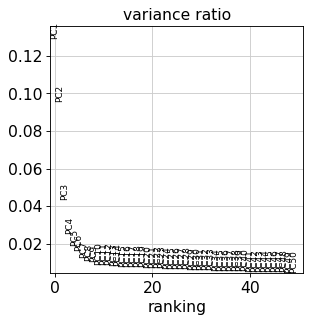

In [8]:
# quick scRNA-seq-like scanpy workflow for NanoString whole transcriptome data

# this data is already normalised, but we need to log1p transform it
sc.pp.log1p(adata_ROI)

# calculating highly variable genes HVGs)
sc.pp.highly_variable_genes(adata_ROI, min_mean=0.0125, max_mean=3, min_disp=0.5)
# subsetting to HVGs
adata_hvg = adata_ROI[:, adata_ROI.var['highly_variable']].copy()

# scaling data and calculating PCs
sc.pp.scale(adata_hvg, max_value=10)
sc.tl.pca(adata_hvg, svd_solver='arpack', n_comps=50)
# plot to decide how many PCs best explain the variance
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50)

In [9]:
# claculating neighborhood graph and 2D UMAP embedding for visualisation
n_PCs = 7
sc.pp.neighbors(adata_hvg, n_neighbors = 7, n_pcs = n_PCs)
sc.tl.umap(adata_hvg, random_state=0)

In [10]:
# make sure ROI indices match
Kidney_Sample_Annotations = Kidney_Sample_Annotations.loc[adata_hvg.obs_names,:]

# add metadata
for col in Kidney_Sample_Annotations:
    #print(col)
    adata_hvg.obs.loc[Kidney_Sample_Annotations.index, col] = Kidney_Sample_Annotations.loc[:,col]

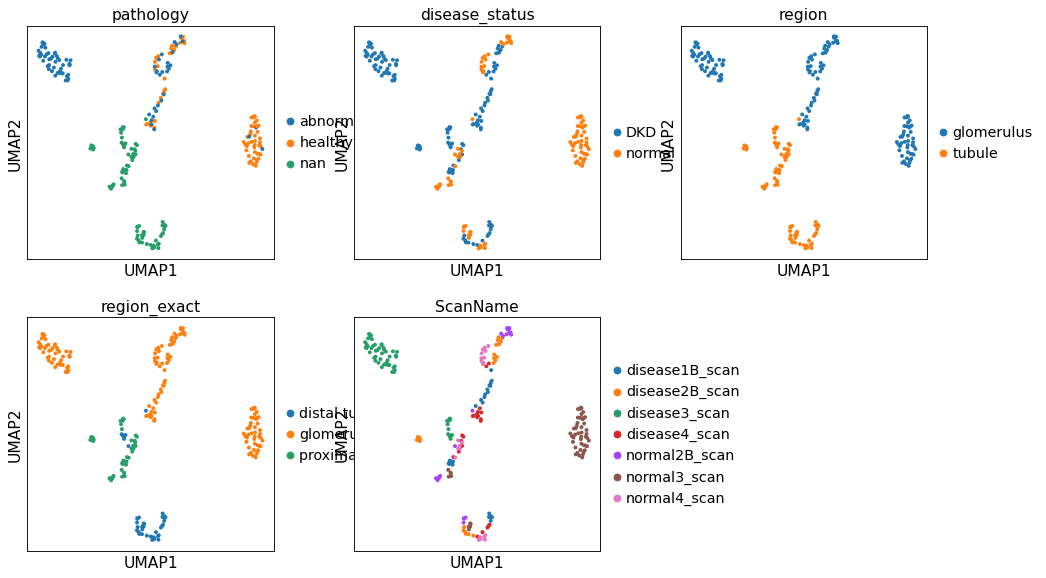

In [12]:
# visualise the 2D UMAP
sc.pl.umap(adata_hvg, color = ['pathology','disease_status','region','region_exact','ScanName',
                              ], ncols=3,
          size=50)

# saving 2D UMAP coordinates for later visualisation
UMAP_2d_coords = pd.DataFrame(adata_hvg.obsm['X_umap'], columns=['x_2d','y_2d'], index=adata_hvg.obs_names)

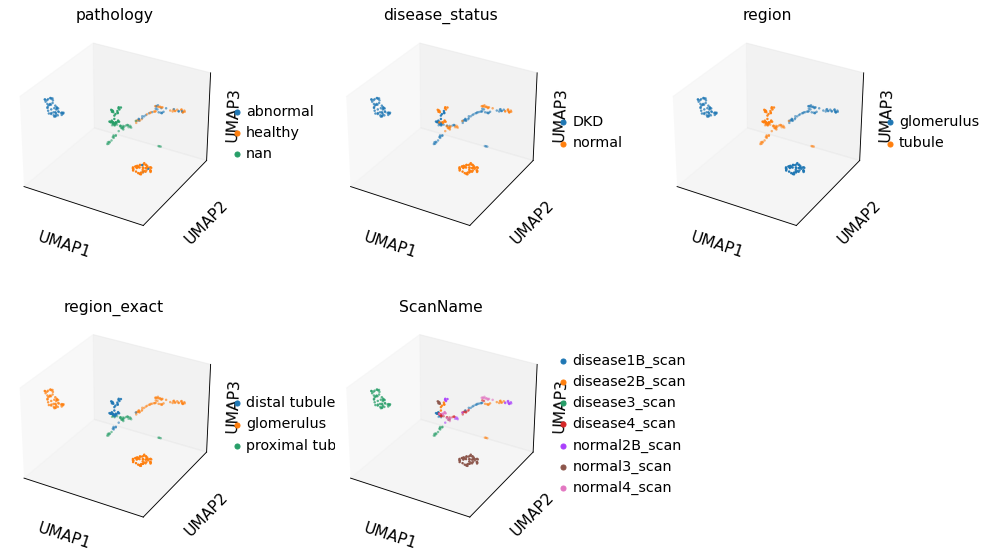

In [13]:
# calculating also a 3D UMAP
sc.tl.umap(adata_hvg, random_state=0,
          n_components=3)

# visualise the 3D UMAP
sc.pl.umap(adata_hvg, color = ['pathology','disease_status','region','region_exact','ScanName',
                              ], ncols=3,
           projection='3d',
          size=50)

# saving 3D UMAP oordinates for later visualisation
UMAP_3d_coords = pd.DataFrame(adata_hvg.obsm['X_umap'], columns=['x_3d','y_3d','z_3d'], index=adata_hvg.obs_names)

### Getting cell type deconvolution data for NanoString ROIs

In [15]:
# formatting columns
Kidney_Spatial_Decon.columns = ['Alias'] + [elem.replace('.','-') for elem in Kidney_Spatial_Decon.columns[1:]]

# adding cell type names into Kidney_Spatial_Decon
Kidney_Spatial_Decon['cell_type_general'] = list(Cell_Types_for_Spatial_Decon.set_index('Alias').loc[Kidney_Spatial_Decon['Alias'],
                                                                                               'cell_type_general'])

In [16]:
# aggregating cell type proportions for cell types in 'cell_type_general'
aggregation_functions = {'Alias': 'first'}
for col in Kidney_Spatial_Decon[1:-1]:
    aggregation_functions[col] = 'sum'
    
Kidney_Spatial_Decon_merged = Kidney_Spatial_Decon.groupby(Kidney_Spatial_Decon['cell_type_general']).aggregate(aggregation_functions)

In [17]:
def add_ct_deconv(adata_obj, sample_ID, celltype):
    return(Kidney_Spatial_Decon_merged.loc[celltype,sample_ID])
    
for celltype in list(Kidney_Spatial_Decon_merged.index):
    #print(celltype)
    adata_hvg.obs['CT_deconv_' + celltype] = [Kidney_Spatial_Decon_merged.loc[celltype, sample_ID] for sample_ID in adata_hvg.obs['Sample_ID']]

In [18]:
# adding coordinates of the UMAP
adata_hvg.obs['x_2d_UMAP'] = UMAP_2d_coords['x_2d']
adata_hvg.obs['y_2d_UMAP'] = UMAP_2d_coords['y_2d']

adata_hvg.obs['x_3d_UMAP'] = UMAP_3d_coords['x_3d']
adata_hvg.obs['y_3d_UMAP'] = UMAP_3d_coords['y_3d']
adata_hvg.obs['z_3d_UMAP'] = UMAP_3d_coords['z_3d']

In [20]:
# adding the corresponding image name to be displayed in ImJoy web browser
# for all file names see: https://drive.google.com/drive/folders/1N3_ybrwg17SDsm0oCxvFOQUsfAsIDHM2
def add_img_names(adata_obj, barcode):
    
    curr_element_of_name = barcode.split(' | ')
    
    #print(curr_element_of_name)
    
    if curr_element_of_name[2] == 'Geometric Segment':
        addition = '' # don't add anything to the name in the end
    elif curr_element_of_name[2] == 'PanCK':
        addition = ' - PanCK'
    elif curr_element_of_name[2] == 'neg':
        addition = ' - neg'
    else:
        print('error')
        
    file_name = curr_element_of_name[0] + ' - ' + curr_element_of_name[1] + addition
    
    return(file_name)

In [21]:
adata_hvg.obs['barcode'] = adata_hvg.obs.index

In [22]:
adata_hvg.obs['Image_file_name'] = adata_hvg.obs['barcode'].apply(lambda x: add_img_names(adata_hvg, x))

In [23]:
adata_hvg.obs.head()

,SlideName,ScanName,ROILabel,SegmentLabel,Sample_ID,AOISurfaceArea,AOINucleiCount,ROICoordinateX,ROICoordinateY,RawReads,...,CT_deconv_Private,CT_deconv_Proximal_tubular_cells,CT_deconv_Th cell,x_2d_UMAP,y_2d_UMAP,x_3d_UMAP,y_3d_UMAP,z_3d_UMAP,barcode,Image_file_name
disease3_scan | 001 | PanCK,disease3,disease3_scan,1,PanCK,DSP-1001250007864-D-H01,22152.10924,183,23572,-39228,7485137,...,0.0,1.813119,0.0,-0.500660,3.276752,6.381473,6.985444,1.439555,disease3_scan | 001 | PanCK,disease3_scan - 001 - PanCK
disease3_scan | 001 | neg,disease3,disease3_scan,1,neg,DSP-1001250007864-D-H02,71817.92407,421,23572,-39228,11365209,...,0.0,4.074634,0.0,-0.559657,4.913762,5.937518,5.829592,-0.250983,disease3_scan | 001 | neg,disease3_scan - 001 - neg
disease3_scan | 002 | PanCK,disease3,disease3_scan,2,PanCK,DSP-1001250007864-D-H03,37316.69780,323,22404,-47078,5764010,...,0.0,1.328950,0.0,-0.405638,2.965492,6.614474,7.309767,1.312996,disease3_scan | 002 | PanCK,disease3_scan - 002 - PanCK
disease3_scan | 002 | neg,disease3,disease3_scan,2,neg,DSP-1001250007864-D-H04,102112.72680,565,22404,-47078,12870214,...,0.0,2.404160,0.0,-0.443905,4.878418,5.885879,6.070858,0.006340,disease3_scan | 002 | neg,disease3_scan - 002 - neg
disease3_scan | 003 | PanCK,disease3,disease3_scan,3,PanCK,DSP-1001250007864-D-H05,18398.68515,162,26308,-51612,3411689,...,0.0,3.365717,0.0,-0.755206,3.418527,6.229037,6.997135,0.875100,disease3_scan | 003 | PanCK,disease3_scan - 003 - PanCK


In [24]:
# convreting all column names to lowercase for java script
adata_hvg.obs.columns = [elem.lower() for elem in adata_hvg.obs.columns]


In [25]:
adata_hvg.obs.to_csv('./table_for_visualisation_ROIs.csv')

In [26]:
adata_hvg.obs.columns

Index(['slidename', 'scanname', 'roilabel', 'segmentlabel', 'sample_id',
       'aoisurfacearea', 'aoinucleicount', 'roicoordinatex', 'roicoordinatey',
       'rawreads', 'trimmedreads', 'stitchedreads', 'alignedreads',
       'deduplicatedreads', 'sequencingsaturation', 'umiq30', 'rtsq30',
       'disease_status', 'pathology', 'region', 'loq', 'normalizationfactor',
       'roireportx', 'roireporty', 'idx', 'region_exact', 'ct_deconv_b cell',
       'ct_deconv_cd8 t cell', 'ct_deconv_dc',
       'ct_deconv_distal_tubules_and_collecting_duct', 'ct_deconv_endothelium',
       'ct_deconv_loop_of_henle', 'ct_deconv_mnp', 'ct_deconv_mast cell',
       'ct_deconv_mesangial_cells', 'ct_deconv_nk cell', 'ct_deconv_nkt cell',
       'ct_deconv_nephron_epithelium', 'ct_deconv_neutrophil',
       'ct_deconv_podocytes', 'ct_deconv_private',
       'ct_deconv_proximal_tubular_cells', 'ct_deconv_th cell', 'x_2d_umap',
       'y_2d_umap', 'x_3d_umap', 'y_3d_umap', 'z_3d_umap', 'barcode',
       'ima